# Load packages

In [1]:
import io
import boto3
import sagemaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [2]:
pip install pandas --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


# Ingest Data

### Load in Ethnicity over 18 dataset from source folder and strip out the fields of interest.  

In [3]:
#It was decided subset the datasets in python before loading into Athena as it is much easier to subset the indididual tables and merge them as opposed to merge the table and subset the final dataset with hundereds of columns.
#Also, we can use the .dtypes function to get the information used to create the Athena tables later. 

s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Source_Data/ADS_508_2020_CA_Cesus_Demographics_Ethnicity_blck_grp_E.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
Ethnicity = pd.read_csv(response.get("Body"))

Ethnicity_Transformed = Ethnicity[["GEOID", "U7E001", "U7E002", "U7E003"]]
Ethnicity_Transformed = Ethnicity_Transformed.rename(columns={"GEOID":"GEO_ID", "U7E001":"TOTAL_ETHNICTY_18_OVER", "U7E002":"HISP_LATINO_18_OVER", "U7E003":"NOT_HISP_LATINO_18_OVER"}) 

Ethnicity_Transformed.head()

,GEO_ID,TOTAL_ETHNICTY_18_OVER,HISP_LATINO_18_OVER,NOT_HISP_LATINO_18_OVER
0,1500000US060014001001,1540,92,1448
1,1500000US060014001002,1093,57,1036
2,1500000US060014002001,832,74,758
3,1500000US060014002002,820,73,747
4,1500000US060014003001,914,62,852


### Export the subset csv file to s3 for loading into Athena.  

In [4]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Athena_Data/Ethnicity_Over_18/Ethnicity_Over_18.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    Ethnicity_Transformed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [5]:
Ethnicity_data_types = Ethnicity_Transformed.dtypes
print(Ethnicity_data_types)
print('Number of Rows:', Ethnicity_Transformed.shape[0])

GEO_ID                     object
TOTAL_ETHNICTY_18_OVER      int64
HISP_LATINO_18_OVER         int64
NOT_HISP_LATINO_18_OVER     int64
dtype: object
Number of Rows: 25607


### Load in Race over 18 dataset from source folder and strip out the fields of interest.

In [6]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Source_Data/ADS_508_2020_CA_Cesus_Demographics_Race_blck_grp_E.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
Race = pd.read_csv(response.get("Body"))

Race_Transformed = Race[["GEOID", "U7D002", "U7D003", "U7D004", "U7D005", "U7D006", "U7D007", "U7D008"]]
Race_Transformed = Race_Transformed.rename(columns={"GEOID":"GEO_ID" ,"U7D002":"TOTAL_ONE_RACE_18_OVER", "U7D003":"WHITE_ALONE_18_OVER", "U7D004":"BLACK_ALONE_18_OVER", "U7D005":"NATIVE_AM_ALONE_18_OVER", "U7D006":"ASIAN_ALONE_18_OVER", "U7D007":"HAWAIIN_PAC_ISLAND_ALONE_18_OVER", "U7D008":"OTHER_ALONE_18_OVER"})

Race_Transformed.head()

,GEO_ID,TOTAL_ONE_RACE_18_OVER,WHITE_ALONE_18_OVER,BLACK_ALONE_18_OVER,NATIVE_AM_ALONE_18_OVER,ASIAN_ALONE_18_OVER,HAWAIIN_PAC_ISLAND_ALONE_18_OVER,OTHER_ALONE_18_OVER
0,1500000US060014001001,1377,1067,42,2,223,6,37
1,1500000US060014001002,996,638,77,0,265,2,14
2,1500000US060014002001,754,642,12,0,74,2,24
3,1500000US060014002002,735,580,27,0,114,0,14
4,1500000US060014003001,838,683,29,2,110,0,14


### Export the subset csv file to s3 for loading into Athena.  

In [7]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Athena_Data/Race_Over_18/Race_Over_18.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    Race_Transformed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [8]:
Race_data_types = Race_Transformed.dtypes
print(Race_data_types)
print('Number of Rows:', Race_Transformed.shape[0])

GEO_ID                              object
TOTAL_ONE_RACE_18_OVER               int64
WHITE_ALONE_18_OVER                  int64
BLACK_ALONE_18_OVER                  int64
NATIVE_AM_ALONE_18_OVER              int64
ASIAN_ALONE_18_OVER                  int64
HAWAIIN_PAC_ISLAND_ALONE_18_OVER     int64
OTHER_ALONE_18_OVER                  int64
dtype: object
Number of Rows: 25607


### Load in Language Spoken over 18 dataset from source folder and strip out the fields of interest.

In [9]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Source_Data/ADS_508_2020_CA_Cesus_Demographics_Language_Spoken_At_Home_Datasets.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
Language_Spoken = pd.read_csv(response.get("Body"))

TOTAL_LANGUAGE_SPOKEN_18_OVER = Language_Spoken["B16004_024E"] + Language_Spoken["B16004_046E"]
Language_Spoken["TOTAL_LANGUAGE_SPOKEN_18_OVER"] = TOTAL_LANGUAGE_SPOKEN_18_OVER

TOTAL_ENGLISH_NOT_AT_ALL_18_OVER = Language_Spoken["B16004_040E"] + Language_Spoken["B16004_035E"] + Language_Spoken["B16004_045E"] + Language_Spoken["B16004_030E"] + Language_Spoken["B16004_062E"] + Language_Spoken["B16004_057E"] + Language_Spoken["B16004_067E"] + Language_Spoken["B16004_052E"]
Language_Spoken["TOTAL_ENGLISH_NOT_AT_ALL_18_OVER"] = TOTAL_ENGLISH_NOT_AT_ALL_18_OVER

TOTAL_ENGLISH_NOT_WELL_18_OVER = Language_Spoken["B16004_039E"] + Language_Spoken["B16004_034E"] + Language_Spoken["B16004_044E"] + Language_Spoken["B16004_029E"] + Language_Spoken["B16004_061E"] + Language_Spoken["B16004_056E"] + Language_Spoken["B16004_066E"] + Language_Spoken["B16004_051E"]
Language_Spoken["TOTAL_ENGLISH_NOT_WELL_18_OVER"] = TOTAL_ENGLISH_NOT_WELL_18_OVER

TOTAL_ENGLISH_WELL_18_OVER = Language_Spoken["B16004_038E"] + Language_Spoken["B16004_033E"] + Language_Spoken["B16004_043E"] + Language_Spoken["B16004_028E"] + Language_Spoken["B16004_060E"] + Language_Spoken["B16004_055E"] + Language_Spoken["B16004_065E"] + Language_Spoken["B16004_050E"]
Language_Spoken["TOTAL_ENGLISH_WELL_18_OVER"] = TOTAL_ENGLISH_WELL_18_OVER

TOTAL_ENGLISH_VERY_WELL_18_OVER = Language_Spoken["B16004_037E"] + Language_Spoken["B16004_032E"] + Language_Spoken["B16004_042E"] + Language_Spoken["B16004_027E"] + Language_Spoken["B16004_059E"] + Language_Spoken["B16004_054E"] + Language_Spoken["B16004_064E"] + Language_Spoken["B16004_049E"]
Language_Spoken["TOTAL_ENGLISH_VERY_WELL_18_OVER"] = TOTAL_ENGLISH_VERY_WELL_18_OVER

TOTAL_ENGLISH_ONLY_18_OVER = Language_Spoken["B16004_025E"] + Language_Spoken["B16004_047E"]
Language_Spoken["TOTAL_ENGLISH_ONLY_18_OVER"] = TOTAL_ENGLISH_ONLY_18_OVER

Language_Spoken_Transformed = Language_Spoken[["GEO_ID", "TOTAL_LANGUAGE_SPOKEN_18_OVER", "TOTAL_ENGLISH_NOT_AT_ALL_18_OVER", "TOTAL_ENGLISH_NOT_WELL_18_OVER", "TOTAL_ENGLISH_WELL_18_OVER", "TOTAL_ENGLISH_VERY_WELL_18_OVER", "TOTAL_ENGLISH_ONLY_18_OVER"]]

Language_Spoken_Transformed.head()

,GEO_ID,TOTAL_LANGUAGE_SPOKEN_18_OVER,TOTAL_ENGLISH_NOT_AT_ALL_18_OVER,TOTAL_ENGLISH_NOT_WELL_18_OVER,TOTAL_ENGLISH_WELL_18_OVER,TOTAL_ENGLISH_VERY_WELL_18_OVER,TOTAL_ENGLISH_ONLY_18_OVER
0,1500000US060014001001,1320,0,0,0,238,1082
1,1500000US060014001002,1149,0,0,66,268,815
2,1500000US060014002001,754,0,4,11,70,669
3,1500000US060014002002,905,0,20,23,116,746
4,1500000US060014003001,927,0,0,0,108,819


### Export the subset csv file to s3 for loading into Athena.  

In [10]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Athena_Data/Language_Spoken_At_Home/Language_Spoken_At_Home.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    Language_Spoken_Transformed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [11]:
Language_Spoken_data_types = Language_Spoken_Transformed.dtypes
print(Language_Spoken_data_types)
print('Number of Rows:', Language_Spoken_Transformed.shape[0])

GEO_ID                              object
TOTAL_LANGUAGE_SPOKEN_18_OVER        int64
TOTAL_ENGLISH_NOT_AT_ALL_18_OVER     int64
TOTAL_ENGLISH_NOT_WELL_18_OVER       int64
TOTAL_ENGLISH_WELL_18_OVER           int64
TOTAL_ENGLISH_VERY_WELL_18_OVER      int64
TOTAL_ENGLISH_ONLY_18_OVER           int64
dtype: object
Number of Rows: 25607


### Load in Household Income dataset from source folder and strip out the fields of interest.

In [12]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Source_Data/ADS_508_2020_CA_Cesus_Demographics_HHIncome.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
HHIncome = pd.read_csv(response.get("Body"))

HHIncome_Transformed = HHIncome[["GEO_ID", "B19001_001E", "B19001_002E", "B19001_003E", "B19001_004E", "B19001_005E", "B19001_006E", "B19001_007E", "B19001_008E", "B19001_009E", "B19001_010E", "B19001_011E", "B19001_012E", "B19001_013E", "B19001_014E", "B19001_015E", "B19001_016E", "B19001_017E"]]

HHIncome_Transformed = HHIncome_Transformed.rename(columns={"B19001_001E":"TOTAL_HHINCOME", "B19001_002E":"LESS_THAN_10K", "B19001_003E":"10K_TO_14999", "B19001_004E":"15K_TO_19999", "B19001_005E":"20K_TO_24999", "B19001_006E":"25K_TO_29999", "B19001_007E":"30K_TO_34999", "B19001_008E":"35K_TO_39999", "B19001_009E":"40K_TO_44999", "B19001_010E":"45K_TO_49999", "B19001_011E":"50K_TO_59999", "B19001_012E":"60K_TO_74999", "B19001_013E":"75K_TO_99999", "B19001_014E":"100K_TO_124999", "B19001_015E":"125K_TO_149999", "B19001_016E":"150K_TO_199999", "B19001_017E":"200K_OR_MORE"}) 

HHIncome_Transformed.head()

,GEO_ID,TOTAL_HHINCOME,LESS_THAN_10K,10K_TO_14999,15K_TO_19999,20K_TO_24999,25K_TO_29999,30K_TO_34999,35K_TO_39999,40K_TO_44999,45K_TO_49999,50K_TO_59999,60K_TO_74999,75K_TO_99999,100K_TO_124999,125K_TO_149999,150K_TO_199999,200K_OR_MORE
0,1500000US060014001001,644,10,0,52,13,6,7,0,0,9,9,8,60,67,38,35,330
1,1500000US060014001002,630,37,6,0,6,7,0,7,0,8,23,9,7,25,54,47,394
2,1500000US060014002001,417,0,6,0,0,0,4,0,5,7,6,10,21,41,6,68,243
3,1500000US060014002002,413,0,5,0,0,0,0,23,0,0,12,27,37,44,38,54,173
4,1500000US060014003001,423,0,0,0,0,13,0,0,38,0,0,16,29,6,0,71,250


### Export the subset csv file to s3 for loading into Athena.  

In [13]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Athena_Data/HHIncome/HHIncome.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    HHIncome_Transformed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [14]:
HHIncome_data_types = HHIncome_Transformed.dtypes
print(HHIncome_data_types)
print('Number of Rows:', HHIncome_Transformed.shape[0])

GEO_ID            object
TOTAL_HHINCOME     int64
LESS_THAN_10K      int64
10K_TO_14999       int64
15K_TO_19999       int64
20K_TO_24999       int64
25K_TO_29999       int64
30K_TO_34999       int64
35K_TO_39999       int64
40K_TO_44999       int64
45K_TO_49999       int64
50K_TO_59999       int64
60K_TO_74999       int64
75K_TO_99999       int64
100K_TO_124999     int64
125K_TO_149999     int64
150K_TO_199999     int64
200K_OR_MORE       int64
dtype: object
Number of Rows: 25607


### Load in Educational Attainment dataset from source folder and strip out the fields of interest.

In [15]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Source_Data/ADS_508_2020_CA_Cesus_Demographics_Educational_Attainment.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
ED_Attainment = pd.read_csv(response.get("Body"))

SUM_ED_ATTAINMENT_COLUMNS = ED_Attainment["B15003_019E"] + ED_Attainment["B15003_020E"] + ED_Attainment["B15003_021E"] + ED_Attainment["B15003_022E"] + ED_Attainment["B15003_023E"] + ED_Attainment["B15003_024E"] + ED_Attainment["B15003_025E"]
ED_Attainment["TOTAL_GREATER_THAN_HS"] = SUM_ED_ATTAINMENT_COLUMNS

ED_Attainment_Transformed = ED_Attainment[["GEO_ID", "B15003_001E", "B15003_019E", "B15003_020E", "B15003_021E", "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E", "TOTAL_GREATER_THAN_HS"]]

ED_Attainment_Transformed = ED_Attainment_Transformed.rename(columns={"B15003_001E":"TOTAL_ED_ATTAINMENT", "B15003_019E":"SOME_COLLEGE_LESS_THAN_1_YEAR", "B15003_020E":"SOME_COLLEGE_1_YEAR_OR_MORE", "B15003_021E":"AA_DEGREE", "B15003_022E":"BA_DEGREE", "B15003_023E":"MA_DEGREE", "B15003_024E":"PROFESSIONAL_SCHOOL", "B15003_025E":"PHD"})

ED_Attainment_Transformed.head()

,GEO_ID,TOTAL_ED_ATTAINMENT,SOME_COLLEGE_LESS_THAN_1_YEAR,SOME_COLLEGE_1_YEAR_OR_MORE,AA_DEGREE,BA_DEGREE,MA_DEGREE,PROFESSIONAL_SCHOOL,PHD,TOTAL_GREATER_THAN_HS
0,1500000US060014001001,1277,5,75,8,472,403,125,137,1225
1,1500000US060014001002,1135,13,46,21,430,316,125,104,1055
2,1500000US060014002001,731,11,11,18,281,204,142,58,725
3,1500000US060014002002,874,8,57,21,264,317,36,72,775
4,1500000US060014003001,905,0,41,3,381,304,90,27,846


### Export the subset csv file to s3 for loading into Athena.  

In [16]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='Athena_Data/Educational_Attainment/Education_Attainment.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    ED_Attainment_Transformed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [17]:
ED_Attainment_Transformed_data_types = ED_Attainment_Transformed.dtypes
print(ED_Attainment_Transformed_data_types)
print('Number of Rows:', ED_Attainment_Transformed.shape[0])

GEO_ID                           object
TOTAL_ED_ATTAINMENT               int64
SOME_COLLEGE_LESS_THAN_1_YEAR     int64
SOME_COLLEGE_1_YEAR_OR_MORE       int64
AA_DEGREE                         int64
BA_DEGREE                         int64
MA_DEGREE                         int64
PROFESSIONAL_SCHOOL               int64
PHD                               int64
TOTAL_GREATER_THAN_HS             int64
dtype: object
Number of Rows: 25607


# Create the Athena database

### Install packages

In [18]:
pip install pyathena

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [19]:
from pyathena import connect

### Create database and set environment parameters

In [20]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [21]:
ingest_create_athena_db_passed = False

In [22]:
database_name = "ADS_508_Census_Data_Transformed"

In [23]:
s3_staging_dir = "s3://{0}/athena/staging/".format(bucket)

In [24]:
#Connection String

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [25]:
#Create database

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS ADS_508_Census_Data_Transformed


""


In [26]:
#s3 Bucket

census_data_dir = 's3://ads508data/Athena_Data/'

In [27]:
# SQL statement to create Educational_Attainment table

table_name ='Educational_Attainment'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                GEO_ID string,
                TOTAL_ED_ATTAINMENT int,
                SOME_COLLEGE_LESS_THAN_1_YEAR int,
                SOME_COLLEGE_1_YEAR_OR_MORE int,
                AA_DEGREE int,
                BA_DEGREE int,
                MA_DEGREE int,
                PHD int,
                PROFESSIONAL_SCHOOL int,
                TOTAL_GREATER_THAN_HS int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{census_data_dir}/{table_name}/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,geo_id,total_ed_attainment,some_college_less_than_1_year,some_college_1_year_or_more,aa_degree,ba_degree,ma_degree,phd,professional_school,total_greater_than_hs
0,1500000US060014001001,1277,5,75,8,472,403,125,137,1225
1,1500000US060014001002,1135,13,46,21,430,316,125,104,1055
2,1500000US060014002001,731,11,11,18,281,204,142,58,725
3,1500000US060014002002,874,8,57,21,264,317,36,72,775
4,1500000US060014003001,905,0,41,3,381,304,90,27,846


In [28]:
# SQL statement to create Ethnicity_Over_18 table

table_name ='Ethnicity_Over_18'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                GEO_ID string,
                TOTAL_ETHNICITY_18_OVER int,
                HISP_LATINO_18_OVER int,
                NOT_HISP_LATINO_18_OVER int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{census_data_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,geo_id,total_ethnicity_18_over,hisp_latino_18_over,not_hisp_latino_18_over
0,1500000US060014001001,1540,92,1448
1,1500000US060014001002,1093,57,1036
2,1500000US060014002001,832,74,758
3,1500000US060014002002,820,73,747
4,1500000US060014003001,914,62,852


In [29]:
# SQL statement to create Race_Over_18 table

table_name ='Race_Over_18'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                GEO_ID string,
                TOTAL_ONE_RACE_18_OVER int,
                WHITE_ALONE_18_OVER int,
                BLACK_ALONE_18_OVER int,
                NATIVE_AM_ALONE_18_OVER int,
                ASIAN_ALONE_18_OVER int,
                HAWAIIN_PAC_ISLAND_ALONE_18_OVER int,
                OTHER_ALONE_18_OVER int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{census_data_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,geo_id,total_one_race_18_over,white_alone_18_over,black_alone_18_over,native_am_alone_18_over,asian_alone_18_over,hawaiin_pac_island_alone_18_over,other_alone_18_over
0,1500000US060014001001,1377,1067,42,2,223,6,37
1,1500000US060014001002,996,638,77,0,265,2,14
2,1500000US060014002001,754,642,12,0,74,2,24
3,1500000US060014002002,735,580,27,0,114,0,14
4,1500000US060014003001,838,683,29,2,110,0,14


In [30]:
# SQL statement to create Language_Spoken_At_Home table

table_name ='Language_Spoken_At_Home'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                GEO_ID string,
                TOTAL_LANGUAGE_SPOKEN_18_OVER int,
                TOTAL_ENGLISH_NOT_AT_ALL_18_OVER int,
                TOTAL_ENGLISH_NOT_WELL_18_OVER int,
                TOTAL_ENGLISH_WELL_18_OVER int,
                TOTAL_ENGLISH_VERY_WELL_18_OVER int,
                TOTAL_ENGLISH_ONLY_18_OVER int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{census_data_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,geo_id,total_language_spoken_18_over,total_english_not_at_all_18_over,total_english_not_well_18_over,total_english_well_18_over,total_english_very_well_18_over,total_english_only_18_over
0,1500000US060014001001,1320,0,0,0,238,1082
1,1500000US060014001002,1149,0,0,66,268,815
2,1500000US060014002001,754,0,4,11,70,669
3,1500000US060014002002,905,0,20,23,116,746
4,1500000US060014003001,927,0,0,0,108,819


In [31]:
# SQL statement to create HHIncome table

table_name ='HHIncome'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                GEO_ID string,
                TOTAL_HHINCOME int,
                LESS_THAN_10K int,
                10K_TO_14999 int,
                15K_TO_19999 int,
                20K_TO_24999 int,
                25K_TO_29999 int,
                30K_TO_34999 int,
                35K_TO_39999 int,
                40K_TO_44999 int,
                45K_TO_49999 int,
                50K_TO_59999 int,
                60K_TO_74999 int,
                75K_TO_99999 int,
                100K_TO_124999 int,
                125K_TO_149999 int,
                150K_TO_199999 int,
                200K_OR_MORE int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{census_data_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,geo_id,total_hhincome,less_than_10k,10k_to_14999,15k_to_19999,20k_to_24999,25k_to_29999,30k_to_34999,35k_to_39999,40k_to_44999,45k_to_49999,50k_to_59999,60k_to_74999,75k_to_99999,100k_to_124999,125k_to_149999,150k_to_199999,200k_or_more
0,1500000US060014001001,644,10,0,52,13,6,7,0,0,9,9,8,60,67,38,35,330
1,1500000US060014001002,630,37,6,0,6,7,0,7,0,8,23,9,7,25,54,47,394
2,1500000US060014002001,417,0,6,0,0,0,4,0,5,7,6,10,21,41,6,68,243
3,1500000US060014002002,413,0,5,0,0,0,0,23,0,0,12,27,37,44,38,54,173
4,1500000US060014003001,423,0,0,0,0,13,0,0,38,0,0,16,29,6,0,71,250


In [32]:
#Join all 5 tables

Merged_Census_Data = pd.read_sql_query(
        f'''select *       
        from {database_name}.Educational_Attainment 
        left outer join {database_name}.HHIncome on (Educational_Attainment.geo_id = HHIncome.geo_id) 
        left outer join {database_name}.Language_Spoken_At_Home on (Educational_Attainment.geo_id = Language_Spoken_At_Home.geo_id) 
        left outer join {database_name}.Race_Over_18 on (Educational_Attainment.geo_id = Race_Over_18.geo_id) 
        left outer join {database_name}.Ethnicity_Over_18 on (Educational_Attainment.geo_id = Ethnicity_Over_18.geo_id)''', conn)


In [33]:
Merged_Census_Data = Merged_Census_Data.loc[:,~Merged_Census_Data.columns.duplicated()]

In [34]:
Merged_Census_Data.head()

,geo_id,total_ed_attainment,some_college_less_than_1_year,some_college_1_year_or_more,aa_degree,ba_degree,ma_degree,phd,professional_school,total_greater_than_hs,...,total_one_race_18_over,white_alone_18_over,black_alone_18_over,native_am_alone_18_over,asian_alone_18_over,hawaiin_pac_island_alone_18_over,other_alone_18_over,total_ethnicity_18_over,hisp_latino_18_over,not_hisp_latino_18_over
0,1500000US060372371022,1074,29,140,7,51,0,11,70,308,...,1207,78,289,43,6,12,779,1392,1050,342
1,1500000US060372372011,678,9,37,12,27,4,0,8,97,...,743,100,140,43,6,0,454,909,717,192
2,1500000US060372372013,641,31,72,21,32,0,0,0,156,...,592,54,186,16,1,0,335,683,473,210
3,1500000US060372372021,827,0,189,48,48,0,0,0,285,...,744,92,178,19,4,1,450,891,656,235
4,1500000US060372372022,478,0,29,27,15,12,12,12,107,...,507,33,254,14,2,1,203,601,316,285


In [35]:
#Check Shape

print(Merged_Census_Data.shape)

(25607, 43)


## EDA

In [36]:
#Check for missing values

Merged_Census_Data.isnull().sum()

geo_id                              0
total_ed_attainment                 0
some_college_less_than_1_year       0
some_college_1_year_or_more         0
aa_degree                           0
ba_degree                           0
ma_degree                           0
phd                                 0
professional_school                 0
total_greater_than_hs               0
total_hhincome                      0
less_than_10k                       0
10k_to_14999                        0
15k_to_19999                        0
20k_to_24999                        0
25k_to_29999                        0
30k_to_34999                        0
35k_to_39999                        0
40k_to_44999                        0
45k_to_49999                        0
50k_to_59999                        0
60k_to_74999                        0
75k_to_99999                        0
100k_to_124999                      0
125k_to_149999                      0
150k_to_199999                      0
200k_or_more

##### No missing values

In [37]:
pip install prettytable

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [38]:
#Find Min, Max, Median, and Mean

from prettytable import PrettyTable

myTable = PrettyTable(["Variable", "Min", "Max", "Median", "Mean"])
myTable.add_row(["total_ed_attainment", Merged_Census_Data["total_ed_attainment"].min(), Merged_Census_Data["total_ed_attainment"].max(), Merged_Census_Data["total_ed_attainment"].median(), Merged_Census_Data["total_ed_attainment"].mean()])
myTable.add_row(["some_college_less_than_1_year", Merged_Census_Data["some_college_less_than_1_year"].min(), Merged_Census_Data["some_college_less_than_1_year"].max(), Merged_Census_Data["some_college_less_than_1_year"].median(), Merged_Census_Data["some_college_less_than_1_year"].mean()])
myTable.add_row(["some_college_1_year_or_more", Merged_Census_Data["some_college_1_year_or_more"].min(), Merged_Census_Data["some_college_1_year_or_more"].max(), Merged_Census_Data["some_college_1_year_or_more"].median(), Merged_Census_Data["some_college_1_year_or_more"].mean()])
myTable.add_row(["aa_degree", Merged_Census_Data["aa_degree"].min(), Merged_Census_Data["aa_degree"].max(), Merged_Census_Data["aa_degree"].median(), Merged_Census_Data["aa_degree"].mean()])
myTable.add_row(["ba_degree", Merged_Census_Data["ba_degree"].min(), Merged_Census_Data["ba_degree"].max(), Merged_Census_Data["ba_degree"].median(), Merged_Census_Data["ba_degree"].mean()])
myTable.add_row(["ma_degree", Merged_Census_Data["ma_degree"].min(), Merged_Census_Data["ma_degree"].max(), Merged_Census_Data["ma_degree"].median(), Merged_Census_Data["ma_degree"].mean()])
myTable.add_row(["professional_school", Merged_Census_Data["professional_school"].min(), Merged_Census_Data["professional_school"].max(), Merged_Census_Data["professional_school"].median(), Merged_Census_Data["professional_school"].mean()])
myTable.add_row(["phd", Merged_Census_Data["phd"].min(), Merged_Census_Data["phd"].max(), Merged_Census_Data["phd"].median(), Merged_Census_Data["phd"].mean()])
myTable.add_row(["total_greater_than_hs", Merged_Census_Data["total_greater_than_hs"].min(), Merged_Census_Data["total_greater_than_hs"].max(), Merged_Census_Data["total_greater_than_hs"].median(), Merged_Census_Data["total_greater_than_hs"].mean()])
myTable.add_row(["total_hhincome", Merged_Census_Data["total_hhincome"].min(), Merged_Census_Data["total_hhincome"].max(), Merged_Census_Data["total_hhincome"].median(), Merged_Census_Data["total_hhincome"].mean()])
myTable.add_row(["less_than_10k", Merged_Census_Data["less_than_10k"].min(), Merged_Census_Data["less_than_10k"].max(), Merged_Census_Data["less_than_10k"].median(), Merged_Census_Data["less_than_10k"].mean()])
myTable.add_row(["10k_to_14999", Merged_Census_Data["10k_to_14999"].min(), Merged_Census_Data["10k_to_14999"].max(), Merged_Census_Data["10k_to_14999"].median(), Merged_Census_Data["10k_to_14999"].mean()])
myTable.add_row(["15k_to_19999", Merged_Census_Data["15k_to_19999"].min(), Merged_Census_Data["15k_to_19999"].max(), Merged_Census_Data["15k_to_19999"].median(), Merged_Census_Data["15k_to_19999"].mean()])
myTable.add_row(["20k_to_24999", Merged_Census_Data["20k_to_24999"].min(), Merged_Census_Data["20k_to_24999"].max(), Merged_Census_Data["20k_to_24999"].median(), Merged_Census_Data["20k_to_24999"].mean()])
myTable.add_row(["25k_to_29999", Merged_Census_Data["25k_to_29999"].min(), Merged_Census_Data["25k_to_29999"].max(), Merged_Census_Data["25k_to_29999"].median(), Merged_Census_Data["25k_to_29999"].mean()])
myTable.add_row(["30k_to_34999", Merged_Census_Data["30k_to_34999"].min(), Merged_Census_Data["30k_to_34999"].max(), Merged_Census_Data["30k_to_34999"].median(), Merged_Census_Data["30k_to_34999"].mean()])
myTable.add_row(["35k_to_39999", Merged_Census_Data["35k_to_39999"].min(), Merged_Census_Data["35k_to_39999"].max(), Merged_Census_Data["35k_to_39999"].median(), Merged_Census_Data["35k_to_39999"].mean()])
myTable.add_row(["40k_to_44999", Merged_Census_Data["40k_to_44999"].min(), Merged_Census_Data["40k_to_44999"].max(), Merged_Census_Data["40k_to_44999"].median(), Merged_Census_Data["40k_to_44999"].mean()])
myTable.add_row(["45k_to_49999", Merged_Census_Data["45k_to_49999"].min(), Merged_Census_Data["45k_to_49999"].max(), Merged_Census_Data["45k_to_49999"].median(), Merged_Census_Data["45k_to_49999"].mean()])
myTable.add_row(["50k_to_59999", Merged_Census_Data["45k_to_49999"].min(), Merged_Census_Data["45k_to_49999"].max(), Merged_Census_Data["45k_to_49999"].median(), Merged_Census_Data["45k_to_49999"].mean()])
myTable.add_row(["60k_to_74999", Merged_Census_Data["60k_to_74999"].min(), Merged_Census_Data["60k_to_74999"].max(), Merged_Census_Data["60k_to_74999"].median(), Merged_Census_Data["60k_to_74999"].mean()])
myTable.add_row(["75k_to_99999", Merged_Census_Data["75k_to_99999"].min(), Merged_Census_Data["75k_to_99999"].max(), Merged_Census_Data["75k_to_99999"].median(), Merged_Census_Data["75k_to_99999"].mean()])
myTable.add_row(["100k_to_124999", Merged_Census_Data["100k_to_124999"].min(), Merged_Census_Data["100k_to_124999"].max(), Merged_Census_Data["100k_to_124999"].median(), Merged_Census_Data["100k_to_124999"].mean()])
myTable.add_row(["125k_to_149999", Merged_Census_Data["125k_to_149999"].min(), Merged_Census_Data["125k_to_149999"].max(), Merged_Census_Data["125k_to_149999"].median(), Merged_Census_Data["125k_to_149999"].mean()])
myTable.add_row(["150k_to_199999", Merged_Census_Data["150k_to_199999"].min(), Merged_Census_Data["150k_to_199999"].max(), Merged_Census_Data["150k_to_199999"].median(), Merged_Census_Data["150k_to_199999"].mean()])
myTable.add_row(["200k_or_more", Merged_Census_Data["200k_or_more"].min(), Merged_Census_Data["200k_or_more"].max(), Merged_Census_Data["200k_or_more"].median(), Merged_Census_Data["200k_or_more"].mean()])
myTable.add_row(["total_language_spoken_18_over", Merged_Census_Data["total_language_spoken_18_over"].min(), Merged_Census_Data["total_language_spoken_18_over"].max(), Merged_Census_Data["total_language_spoken_18_over"].median(), Merged_Census_Data["total_language_spoken_18_over"].mean()])
myTable.add_row(["total_english_not_at_all_18_over", Merged_Census_Data["total_english_not_at_all_18_over"].min(), Merged_Census_Data["total_english_not_at_all_18_over"].max(), Merged_Census_Data["total_english_not_at_all_18_over"].median(), Merged_Census_Data["total_english_not_at_all_18_over"].mean()])
myTable.add_row(["total_english_not_well_18_over", Merged_Census_Data["total_english_not_well_18_over"].min(), Merged_Census_Data["total_english_not_well_18_over"].max(), Merged_Census_Data["total_english_not_well_18_over"].median(), Merged_Census_Data["total_english_not_well_18_over"].mean()])
myTable.add_row(["total_english_well_18_over", Merged_Census_Data["total_english_well_18_over"].min(), Merged_Census_Data["total_english_well_18_over"].max(), Merged_Census_Data["total_english_well_18_over"].median(), Merged_Census_Data["total_english_well_18_over"].mean()])
myTable.add_row(["total_english_very_well_18_over", Merged_Census_Data["total_english_very_well_18_over"].min(), Merged_Census_Data["total_english_very_well_18_over"].max(), Merged_Census_Data["total_english_very_well_18_over"].median(), Merged_Census_Data["total_english_very_well_18_over"].mean()])
myTable.add_row(["total_english_only_18_over", Merged_Census_Data["total_english_only_18_over"].min(), Merged_Census_Data["total_english_only_18_over"].max(), Merged_Census_Data["total_english_only_18_over"].median(), Merged_Census_Data["total_english_only_18_over"].mean()])
myTable.add_row(["total_one_race_18_over", Merged_Census_Data["total_one_race_18_over"].min(), Merged_Census_Data["total_one_race_18_over"].max(), Merged_Census_Data["total_one_race_18_over"].median(), Merged_Census_Data["total_one_race_18_over"].mean()])
myTable.add_row(["white_alone_18_over", Merged_Census_Data["white_alone_18_over"].min(), Merged_Census_Data["white_alone_18_over"].max(), Merged_Census_Data["white_alone_18_over"].median(), Merged_Census_Data["white_alone_18_over"].mean()])
myTable.add_row(["black_alone_18_over", Merged_Census_Data["black_alone_18_over"].min(), Merged_Census_Data["black_alone_18_over"].max(), Merged_Census_Data["black_alone_18_over"].median(), Merged_Census_Data["black_alone_18_over"].mean()])
myTable.add_row(["native_am_alone_18_over", Merged_Census_Data["native_am_alone_18_over"].min(), Merged_Census_Data["native_am_alone_18_over"].max(), Merged_Census_Data["native_am_alone_18_over"].median(), Merged_Census_Data["native_am_alone_18_over"].mean()])
myTable.add_row(["asian_alone_18_over", Merged_Census_Data["asian_alone_18_over"].min(), Merged_Census_Data["asian_alone_18_over"].max(), Merged_Census_Data["asian_alone_18_over"].median(), Merged_Census_Data["asian_alone_18_over"].mean()])
myTable.add_row(["hawaiin_pac_island_alone_18_over", Merged_Census_Data["total_ed_attainment"].min(), Merged_Census_Data["total_ed_attainment"].max(), Merged_Census_Data["total_ed_attainment"].median(), Merged_Census_Data["total_ed_attainment"].mean()])
myTable.add_row(["total_ethnicity_18_over", Merged_Census_Data["total_ethnicity_18_over"].min(), Merged_Census_Data["total_ethnicity_18_over"].max(), Merged_Census_Data["total_ethnicity_18_over"].median(), Merged_Census_Data["total_ethnicity_18_over"].mean()])
myTable.add_row(["hisp_latino_18_over", Merged_Census_Data["hisp_latino_18_over"].min(), Merged_Census_Data["hisp_latino_18_over"].max(), Merged_Census_Data["hisp_latino_18_over"].median(), Merged_Census_Data["hisp_latino_18_over"].mean()])
myTable.add_row(["not_hisp_latino_18_over", Merged_Census_Data["not_hisp_latino_18_over"].min(), Merged_Census_Data["not_hisp_latino_18_over"].max(), Merged_Census_Data["not_hisp_latino_18_over"].median(), Merged_Census_Data["not_hisp_latino_18_over"].mean()])

print(myTable)

+----------------------------------+-----+-------+--------+--------------------+
|             Variable             | Min |  Max  | Median |        Mean        |
+----------------------------------+-----+-------+--------+--------------------+
|       total_ed_attainment        |  0  | 11608 | 971.0  | 1041.3224118405124 |
|  some_college_less_than_1_year   |  0  |  1905 |  47.0  | 60.85781231694459  |
|   some_college_1_year_or_more    |  0  |  2470 | 135.0  | 156.52493458819853 |
|            aa_degree             |  0  |  1274 |  67.0  | 82.93931346897332  |
|            ba_degree             |  0  |  2207 | 183.0  | 225.12699652438786 |
|            ma_degree             |  0  |  1768 |  61.0  | 92.83309251376576  |
|       professional_school        |  0  |  734  |  0.0   | 17.45768735111493  |
|               phd                |  0  |  507  |  11.0  | 26.07997813097981  |
|      total_greater_than_hs       |  0  |  8351 | 592.0  | 661.8198148943649  |
|          total_hhincome   

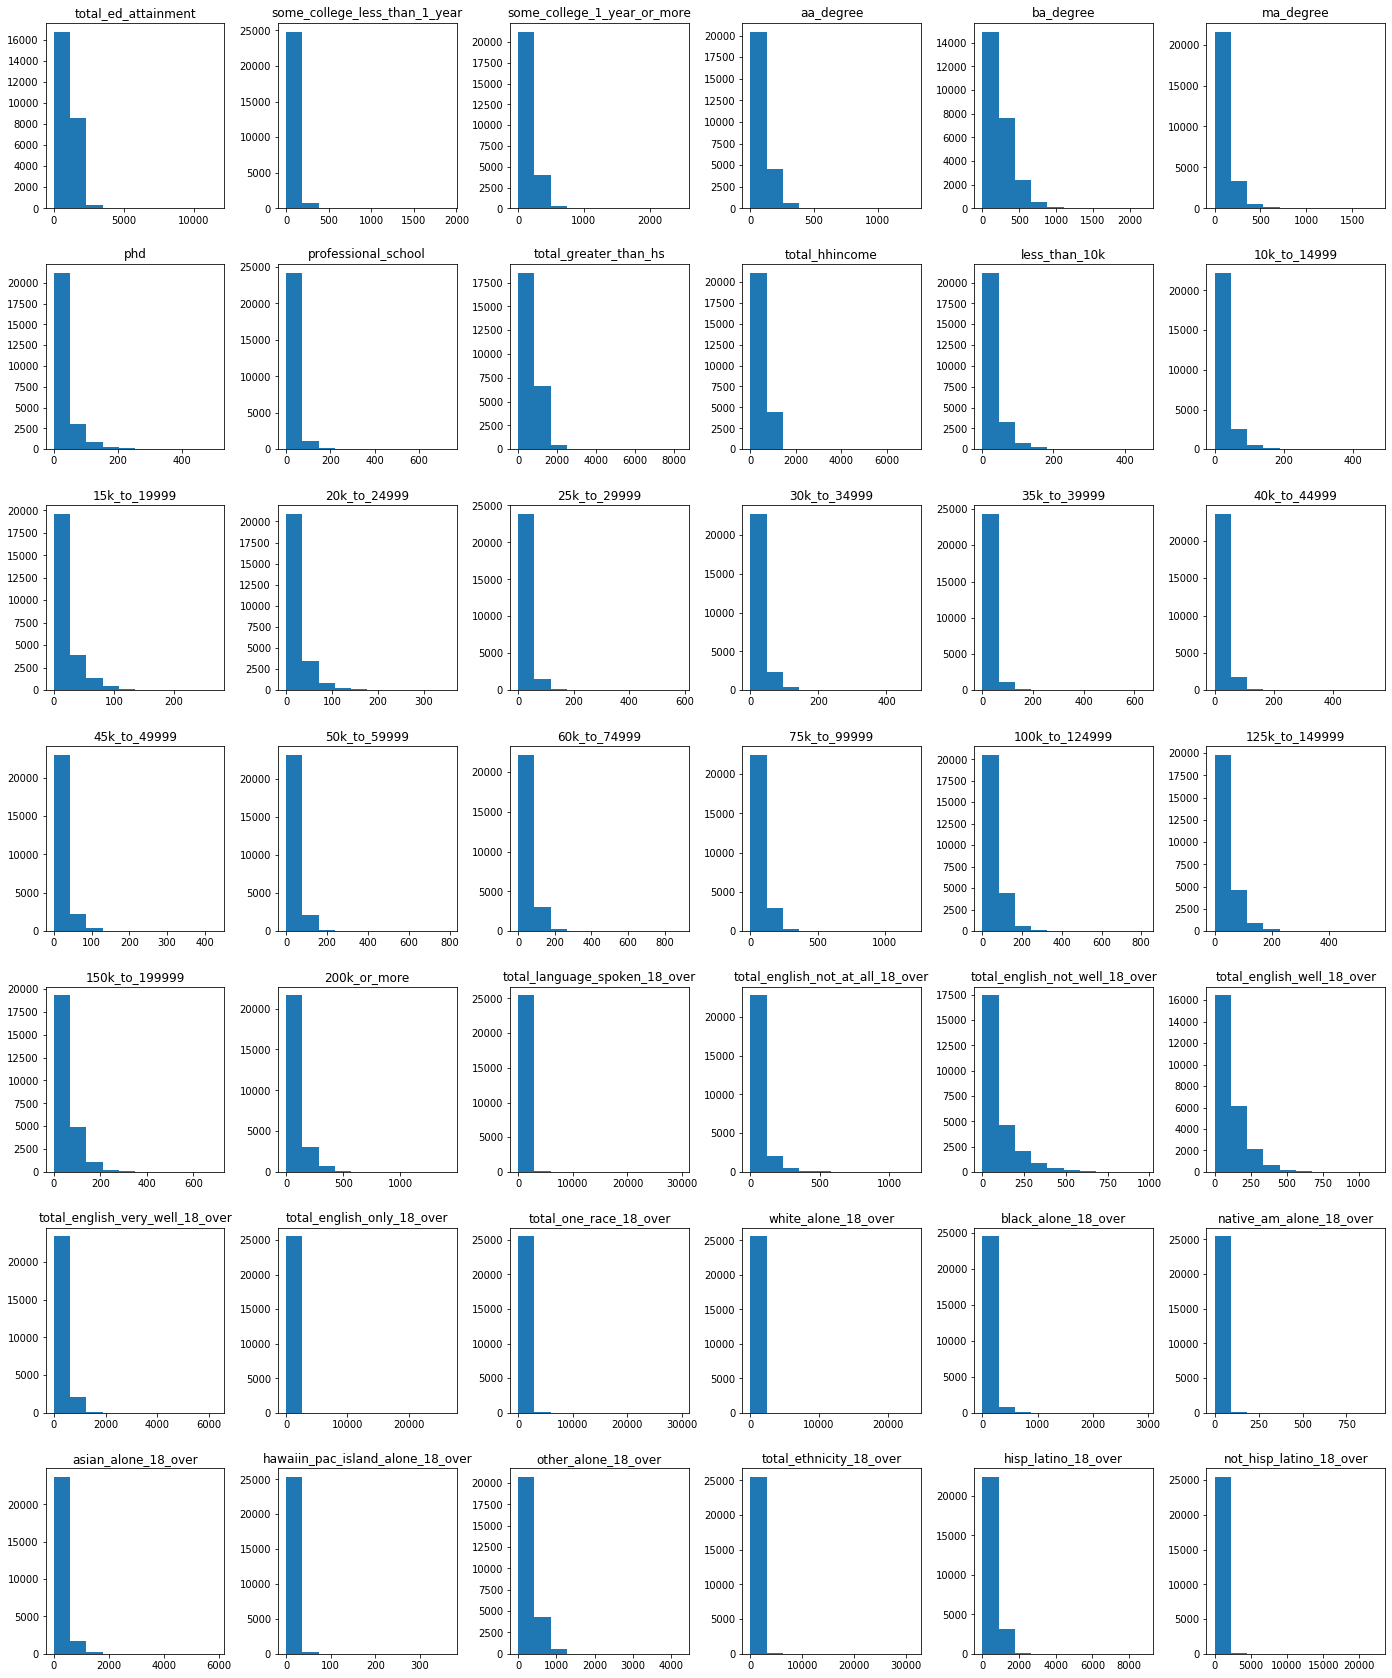

In [39]:
Merged_Census_Data.hist(figsize = (24,30), grid=False)
plt.show()

In [40]:
#Create target class to check for imbalance

Merged_Census_Data['percent_greater_than_hs'] = Merged_Census_Data['total_greater_than_hs']/Merged_Census_Data['total_ed_attainment']

Merged_Census_Data.fillna(value = 0, inplace = True)

In [41]:
print(Merged_Census_Data['percent_greater_than_hs'].head())

0    0.286778
1    0.143068
2    0.243370
3    0.344619
4    0.223849
Name: percent_greater_than_hs, dtype: float64


In [42]:
Merged_Census_Data.loc[Merged_Census_Data['percent_greater_than_hs'] <= .40, 'ed_attainment'] = 0
Merged_Census_Data.loc[Merged_Census_Data['percent_greater_than_hs'] > .40, 'ed_attainment'] = 1

In [43]:
print(Merged_Census_Data['ed_attainment'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ed_attainment, dtype: float64


In [44]:
Merged_Census_Data['ed_attainment'].value_counts()

1.0    21076
0.0     4531
Name: ed_attainment, dtype: int64

In [45]:
#Create percent total variables per block group

Merged_Census_Data['some_college_less_than_1_year_pct'] = Merged_Census_Data['some_college_less_than_1_year']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['some_college_1_year_or_more_pct'] = Merged_Census_Data['some_college_1_year_or_more']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['aa_degree_pct'] = Merged_Census_Data['aa_degree']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['ba_degree_pct'] = Merged_Census_Data['ba_degree']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['ma_degree_pct'] = Merged_Census_Data['ma_degree']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['phd_pct'] = Merged_Census_Data['phd']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['professional_school_pct'] = Merged_Census_Data['professional_school']/Merged_Census_Data['total_ed_attainment']
Merged_Census_Data['less_than_10k_pct'] = Merged_Census_Data['less_than_10k']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['10k_to_14999_pct'] = Merged_Census_Data['10k_to_14999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['15k_to_19999_pct'] = Merged_Census_Data['15k_to_19999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['20k_to_24999_pct'] = Merged_Census_Data['20k_to_24999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['25k_to_29999_pct'] = Merged_Census_Data['25k_to_29999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['30k_to_34999_pct'] = Merged_Census_Data['30k_to_34999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['35k_to_39999_pct'] = Merged_Census_Data['35k_to_39999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['40k_to_44999_pct'] = Merged_Census_Data['40k_to_44999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['45k_to_49999_pct'] = Merged_Census_Data['45k_to_49999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['50k_to_59999_pct'] = Merged_Census_Data['50k_to_59999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['60k_to_74999_pct'] = Merged_Census_Data['60k_to_74999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['75k_to_99999_pct'] = Merged_Census_Data['75k_to_99999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['100k_to_124999_pct'] = Merged_Census_Data['100k_to_124999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['125k_to_149999_pct'] = Merged_Census_Data['125k_to_149999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['150k_to_199999_pct'] = Merged_Census_Data['150k_to_199999']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['200k_or_more_pct'] = Merged_Census_Data['200k_or_more']/Merged_Census_Data['total_hhincome']
Merged_Census_Data['total_english_not_at_all_18_over_pct'] = Merged_Census_Data['total_english_not_at_all_18_over']/Merged_Census_Data['total_language_spoken_18_over']
Merged_Census_Data['total_english_not_well_18_over_pct'] = Merged_Census_Data['total_english_not_well_18_over']/Merged_Census_Data['total_language_spoken_18_over']
Merged_Census_Data['total_english_well_18_over_pct'] = Merged_Census_Data['total_english_well_18_over']/Merged_Census_Data['total_language_spoken_18_over']
Merged_Census_Data['total_english_very_well_18_over_pct'] = Merged_Census_Data['total_english_very_well_18_over']/Merged_Census_Data['total_language_spoken_18_over']
Merged_Census_Data['total_english_only_18_over_pct'] = Merged_Census_Data['total_english_only_18_over']/Merged_Census_Data['total_language_spoken_18_over']
Merged_Census_Data['white_alone_18_over_pct'] = Merged_Census_Data['white_alone_18_over']/Merged_Census_Data['total_one_race_18_over']
Merged_Census_Data['black_alone_18_over_pct'] = Merged_Census_Data['black_alone_18_over']/Merged_Census_Data['total_one_race_18_over']
Merged_Census_Data['native_am_alone_18_over_pct'] = Merged_Census_Data['native_am_alone_18_over']/Merged_Census_Data['total_one_race_18_over']
Merged_Census_Data['asian_alone_18_over_pct'] = Merged_Census_Data['asian_alone_18_over']/Merged_Census_Data['total_one_race_18_over']
Merged_Census_Data['hawaiin_pac_island_alone_18_over_pct'] = Merged_Census_Data['hawaiin_pac_island_alone_18_over']/Merged_Census_Data['total_one_race_18_over']
Merged_Census_Data['hisp_latino_18_over_pct'] = Merged_Census_Data['hisp_latino_18_over']/Merged_Census_Data['total_ethnicity_18_over']
Merged_Census_Data['not_hisp_latino_18_over_pct'] = Merged_Census_Data['not_hisp_latino_18_over']/Merged_Census_Data['total_ethnicity_18_over']

In [46]:
Merged_Census_Data.fillna(value = 0, inplace = True)

In [47]:
Educational_Attainment_Processed =  Merged_Census_Data[['ed_attainment', 'some_college_less_than_1_year_pct','some_college_1_year_or_more_pct', 'aa_degree_pct','ba_degree_pct', 'ma_degree_pct', 'phd_pct', 'professional_school_pct', '10k_to_14999_pct', '15k_to_19999_pct', '20k_to_24999_pct', '25k_to_29999_pct', '30k_to_34999_pct', '35k_to_39999_pct', '45k_to_49999_pct' ,'50k_to_59999_pct' ,'60k_to_74999_pct'
 ,'75k_to_99999_pct' ,'100k_to_124999_pct' ,'125k_to_149999_pct' ,'150k_to_199999_pct' ,'200k_or_more_pct' ,'total_english_not_at_all_18_over_pct' ,'total_english_not_well_18_over_pct' ,'total_english_well_18_over_pct' ,'total_english_very_well_18_over_pct' ,'total_english_only_18_over_pct' ,'white_alone_18_over_pct' ,'black_alone_18_over_pct' ,'native_am_alone_18_over_pct'
 ,'asian_alone_18_over_pct' ,'hawaiin_pac_island_alone_18_over_pct' ,'hisp_latino_18_over_pct' ,'not_hisp_latino_18_over_pct']]

In [48]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(Educational_Attainment_Processed, title="Pandas Profiling Report", minimal=True)

#profile.to_file("profile_output.html")

profile.to_notebook_iframe()

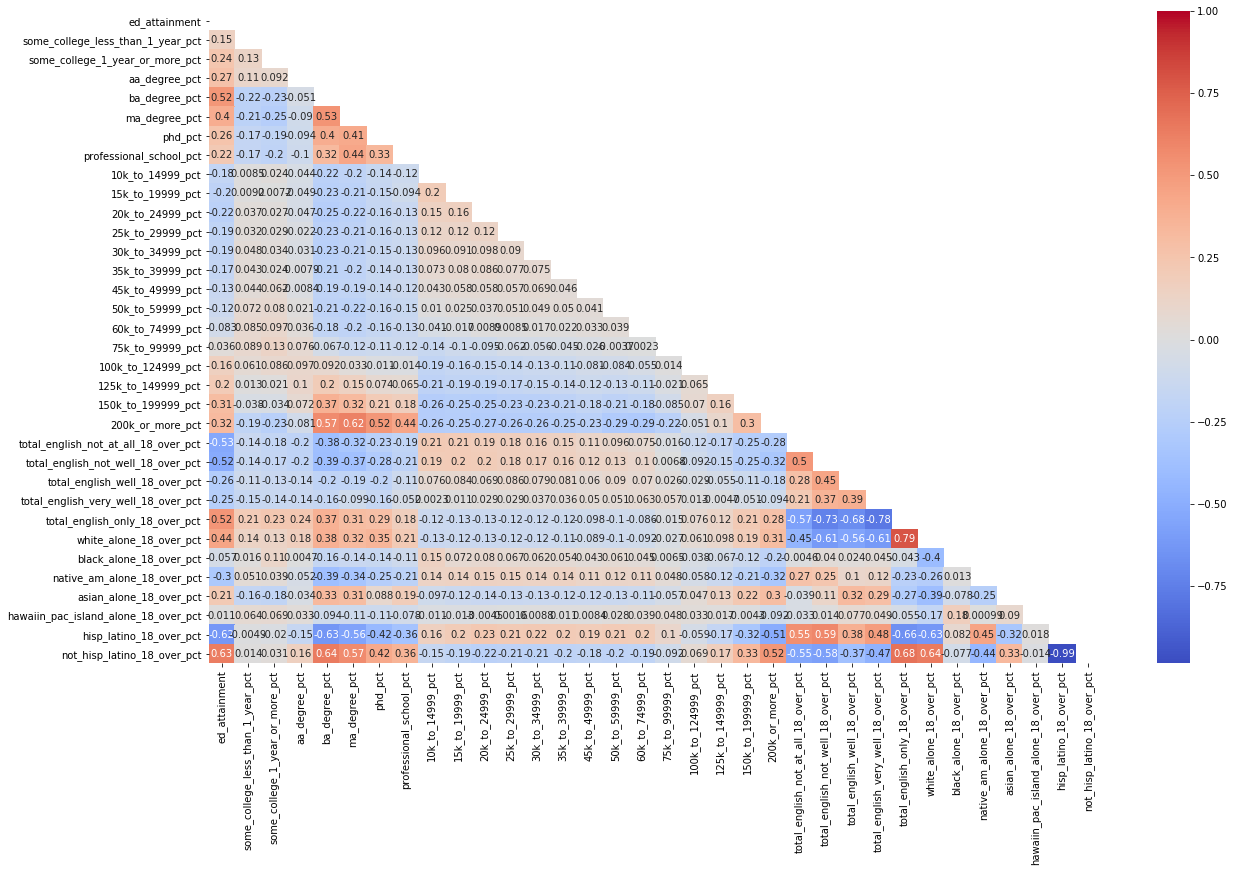

In [49]:
# Create correlation heatmap

mask = np.zeros_like(Educational_Attainment_Processed.corr())
mask[np.triu_indices_from(mask)] = True

merged_corr = Educational_Attainment_Processed.corr()

plt.figure(figsize=(20,12))
sns.heatmap(merged_corr, annot = True, cmap='coolwarm', mask=mask)
plt.show()


#### Observations from correlation heatmap:

##### Higher education degrees correlate positively with higher income (see BA, MA, PHD, and professional degrees with positive correlation coefficients in relation to incomes starting at 150K and higher)
##### ED attainment correlates highly with census responses identifying as white only
##### ED attainment correlates highly with census responses identifying as speaking only english
##### ED attainment correlates highly with responses identifying as not hispanic
##### Speaking english less than very well is negatively correlated with ED attainment
##### Those identifying as native american are negatively correlated with ED attainment
##### Those identifying as asian are positively correlated with ed attainment
##### ED attainment is more positively correlated to incomes starting at 75K, with increasing positive correlation as income increases

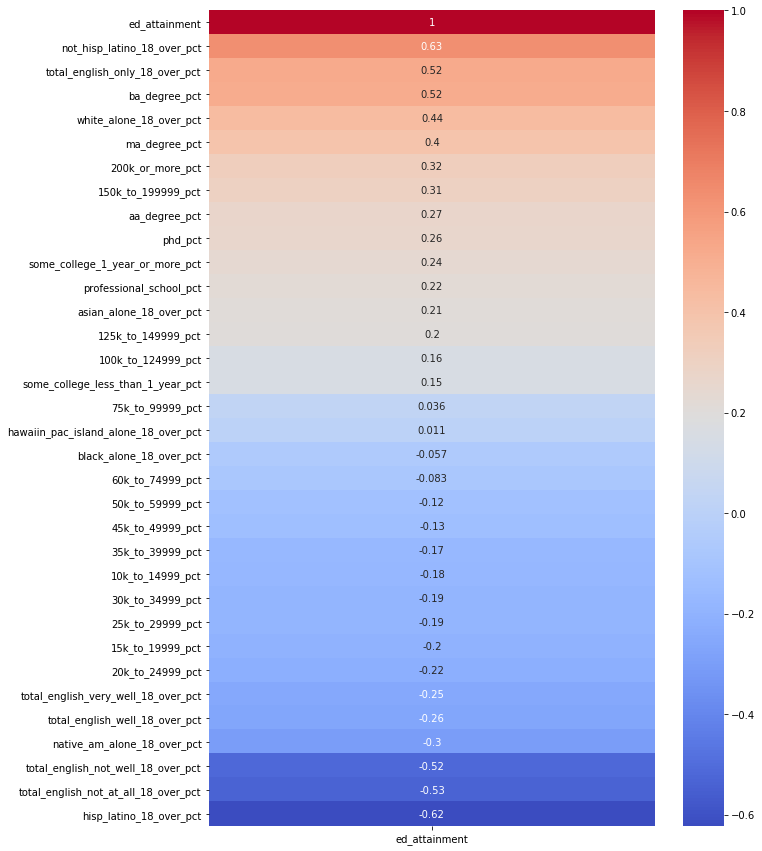

In [50]:
# rank correlations

ED_corr = Educational_Attainment_Processed.corr()[['ed_attainment']].sort_values(by='ed_attainment', ascending=False)

plt.figure(figsize =(10,15))
sns.heatmap(ED_corr, annot = True, cmap='coolwarm')

In [51]:
s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='ML_Data/Educational_Attainment_Processed.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    Educational_Attainment_Processed.to_csv(csv_buffer, index=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [52]:
KEY='ML_Data/Educational_Attainment_Processed.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
ML_Data = pd.read_csv(response.get("Body"))


ML_Data.head()

,ed_attainment,some_college_less_than_1_year_pct,some_college_1_year_or_more_pct,aa_degree_pct,ba_degree_pct,ma_degree_pct,phd_pct,professional_school_pct,10k_to_14999_pct,15k_to_19999_pct,...,total_english_well_18_over_pct,total_english_very_well_18_over_pct,total_english_only_18_over_pct,white_alone_18_over_pct,black_alone_18_over_pct,native_am_alone_18_over_pct,asian_alone_18_over_pct,hawaiin_pac_island_alone_18_over_pct,hisp_latino_18_over_pct,not_hisp_latino_18_over_pct
0,0.0,0.027002,0.130354,0.006518,0.047486,0.000000,0.010242,0.065177,0.119374,0.076321,...,0.113952,0.290723,0.355734,0.064623,0.239437,0.035626,0.004971,0.009942,0.754310,0.245690
1,0.0,0.013274,0.054572,0.017699,0.039823,0.005900,0.000000,0.011799,0.000000,0.000000,...,0.054983,0.489118,0.192440,0.134590,0.188425,0.057873,0.008075,0.000000,0.788779,0.211221
2,0.0,0.048362,0.112324,0.032761,0.049922,0.000000,0.000000,0.000000,0.098246,0.073684,...,0.268973,0.283482,0.293527,0.091216,0.314189,0.027027,0.001689,0.000000,0.692533,0.307467
3,0.0,0.000000,0.228537,0.058041,0.058041,0.000000,0.000000,0.000000,0.067885,0.000000,...,0.085653,0.364026,0.162741,0.123656,0.239247,0.025538,0.005376,0.001344,0.736251,0.263749
4,0.0,0.000000,0.060669,0.056485,0.031381,0.025105,0.025105,0.025105,0.000000,0.000000,...,0.197697,0.071017,0.451056,0.065089,0.500986,0.027613,0.003945,0.001972,0.525790,0.474210


In [53]:
ML_Data.isnull().sum()

ed_attainment                           0
some_college_less_than_1_year_pct       0
some_college_1_year_or_more_pct         0
aa_degree_pct                           0
ba_degree_pct                           0
ma_degree_pct                           0
phd_pct                                 0
professional_school_pct                 0
10k_to_14999_pct                        0
15k_to_19999_pct                        0
20k_to_24999_pct                        0
25k_to_29999_pct                        0
30k_to_34999_pct                        0
35k_to_39999_pct                        0
45k_to_49999_pct                        0
50k_to_59999_pct                        0
60k_to_74999_pct                        0
75k_to_99999_pct                        0
100k_to_124999_pct                      0
125k_to_149999_pct                      0
150k_to_199999_pct                      0
200k_or_more_pct                        0
total_english_not_at_all_18_over_pct    0
total_english_not_well_18_over_pct

#### Check balance of target variable

In [54]:
ML_Data['ed_attainment'] = ML_Data['ed_attainment'].astype(int)

In [55]:
ML_Data['ed_attainment'].value_counts()

1    21076
0     4531
Name: ed_attainment, dtype: int64

In [56]:
pip install imblearn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


#### Rebalance by undersampling majority

In [57]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=123)
X_resampled, y_resampled = rus.fit_resample(ML_Data.iloc[:,0:33], ML_Data['ed_attainment'])

In [58]:
ML_Data1 = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
ML_Data1.columns = ML_Data.columns

In [59]:
ML_Data1['ed_attainment'].value_counts()

0    4531
1    4531
Name: ed_attainment, dtype: int64

In [60]:
#from sklearn.model_selection import train_test_split

#train, test = train_test_split(ML_Data, train_size=0.7, random_state=1)
#valid, test = train_test_split(test, train_size=0.15, random_state=1)

In [61]:
#print('Training:',len(train))
#print('Validation:', len(valid))
#print('Test:', len(test))

In [62]:
#X = list(ML_Data.columns)
#y = 'ed_attainment'
#X.remove(y)

#Xtrain = train[X]
#ytrain = train[y]
#Xtest = test[X]
#ytest = test[y]
#Xvalid = valid[X]
#yvalid = valid[y]

In [63]:
#pip install imblearn

In [64]:
#from imblearn import over_sampling 
#from imblearn.over_sampling import RandomOverSampler

#over_sampler = RandomOverSampler(random_state=123)
#X_res, y_res = over_sampler.fit_resample(Xtrain, ytrain)

In [65]:
#counts = np.unique(y_res, return_counts=True)
#print(counts)

In [66]:
#from sklearn.linear_model import LogisticRegression

#logreg = LogisticRegression()
#logreg.fit(X_res, y_res)

In [67]:
#y_pred = logreg.predict(Xvalid)
#print('Accuracy of logistic regression classifier on test set: {:.20f}'.format(logreg.score(Xvalid, yvalid)))

# Sagemaker Models

In [68]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Gets IAM role
role = get_execution_role()
my_region = boto3.session.Session().region_name # set the region of the instance

# Builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")


Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [69]:
train, test = np.split(ML_Data1.sample(frac=1, random_state=123), [int(0.7 * len(ML_Data1))])
print(train.shape, test.shape)

(6343, 34) (2719, 34)


In [70]:
train

,ed_attainment,some_college_less_than_1_year_pct,some_college_1_year_or_more_pct,aa_degree_pct,ba_degree_pct,ma_degree_pct,phd_pct,professional_school_pct,10k_to_14999_pct,15k_to_19999_pct,...,total_english_well_18_over_pct,total_english_very_well_18_over_pct,total_english_only_18_over_pct,white_alone_18_over_pct,black_alone_18_over_pct,native_am_alone_18_over_pct,asian_alone_18_over_pct,hawaiin_pac_island_alone_18_over_pct,hisp_latino_18_over_pct,not_hisp_latino_18_over_pct
3107,0,0.019676,0.160880,0.059028,0.038194,0.000000,0.005787,0.000000,0.041284,0.045872,...,0.187675,0.302521,0.326797,0.237020,0.088036,0.037246,0.089165,0.002257,0.746988,0
6179,1,0.101695,0.251156,0.098613,0.123267,0.046225,0.000000,0.000000,0.134503,0.000000,...,0.038519,0.053333,0.884444,0.823817,0.003263,0.019576,0.000000,0.000000,0.192547,1
1717,0,0.000000,0.047085,0.053812,0.098655,0.033632,0.000000,0.000000,0.078652,0.048689,...,0.108734,0.406417,0.146168,0.222789,0.008503,0.034014,0.003401,0.000000,0.959318,0
9000,1,0.071757,0.148114,0.109476,0.127875,0.036799,0.000000,0.000000,0.000000,0.000000,...,0.022668,0.027027,0.871840,0.759721,0.061815,0.018943,0.041874,0.002991,0.256950,1
7534,1,0.053412,0.198813,0.163205,0.139466,0.086053,0.014837,0.000000,0.082873,0.080110,...,0.089901,0.227833,0.560345,0.387292,0.045386,0.010590,0.090772,0.000000,0.609572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4683,1,0.051440,0.045267,0.055556,0.341564,0.259259,0.109053,0.037037,0.000000,0.000000,...,0.380117,0.243665,0.280702,0.205674,0.000000,0.007092,0.757092,0.003546,0.067568,1
3343,0,0.031802,0.056537,0.067138,0.218198,0.015018,0.000000,0.000000,0.000000,0.014675,...,0.166049,0.348406,0.180875,0.198440,0.011265,0.026863,0.331889,0.002600,0.579104,0
6081,1,0.014995,0.149016,0.059044,0.377694,0.121837,0.035614,0.000000,0.037367,0.131673,...,0.099344,0.127460,0.682287,0.721119,0.019856,0.004513,0.212996,0.001805,0.095357,1
8156,1,0.055785,0.238636,0.142045,0.194731,0.055269,0.000000,0.000000,0.000000,0.000000,...,0.062295,0.210304,0.673536,0.528860,0.104618,0.015873,0.186869,0.005772,0.336493,1


In [71]:
# Export the dataset to train/train.csv in our S3 bucket per the XGBoost requirements

s3_client = boto3.client("s3")
BUCKET='ads508data'
KEY='train/train.csv'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    train.to_csv(csv_buffer, index=False, header=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 put_object response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object response. Status - {status}")

Successful S3 put_object response. Status - 200


In [72]:
sess = sagemaker.Session()
s3_client = boto3.client("s3")
BUCKET='ads508data'

xgb = sagemaker.estimator.Estimator(
    xgboost_container,role, 
    instance_count=1, 
    instance_type='ml.m5.large',
    output_path='s3://{}/output'.format(BUCKET),
    sagemaker_session=sess
)
xgb.set_hyperparameters(
    max_depth=6,
    eta=0.3,
    gamma=3,
    min_child_weight=1,
    subsample=0.5,
    silent=0,
    objective='binary:logistic',
    num_round=100
)

#### Train model

In [73]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/train/train'.format(BUCKET), content_type='csv')

xgb.fit({'train': s3_input_train})

2022-04-17 22:59:33 Starting - Starting the training job...
2022-04-17 22:59:58 Starting - Preparing the instances for trainingProfilerReport-1650236372: InProgress
.........
2022-04-17 23:01:18 Downloading - Downloading input data......
2022-04-17 23:02:18 Training - Downloading the training image...
2022-04-17 23:02:58 Uploading - Uploading generated training modelArguments: train
[2022-04-17:23:02:50:INFO] Running standalone xgboost training.
[2022-04-17:23:02:50:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-04-17:23:02:50:INFO] File size need to be processed in the node: 3.04mb. Available memory size in the node: 290.99mb
[2022-04-17:23:02:50:INFO] Determined delimiter of CSV input is ','
[23:02:50] S3DistributionType set as FullyReplicated
[23:02:50] 6343x33 matrix with 209319 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[23:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dept

#### Test model

In [74]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m5.large')

-----!

In [75]:
from sagemaker.serializers import CSVSerializer

test_array = test.drop(['ed_attainment'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() 
predictions = xgb_predictor.predict(test_array).decode('utf-8') # predict
predictions_array = np.fromstring(predictions[1:], sep=',') #Create prediction array
print(predictions_array.shape)

(2719,)


In [76]:
cm = pd.crosstab(index=test['ed_attainment'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print(cm)
print("tn: ", tn)
print("tp: ", tp)

Predicted   0.0   1.0
Observed             
0          1377     0
1             0  1342
tn:  1377
tp:  1342


In [77]:
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "Below Avg", "Above Avg"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("Below Avg: ", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Above Avg: ", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 100.0%

Predicted      Below Avg      Above Avg
Observed
Below Avg:     100% (1377)     0% (0)
Above Avg:      0% (0)    100% (1342) 



In [78]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

### References:

Amazon (2021, June 7). Build, train, and deploy a machine learning model
    with Amazon SageMaker.  AWS.  
    https://aws.amazon.com/getting-started/hands-on/build-train-deploy-machine-learning-model-sagemaker/
